(8501, 119)
119
Train Epoch: 1 [0/6800 (0%)]	Loss: 2.226930
Train Epoch: 1 [320/6800 (5%)]	Loss: 1.877414
Train Epoch: 1 [640/6800 (9%)]	Loss: 1.753052
Train Epoch: 1 [960/6800 (14%)]	Loss: 1.850634
Train Epoch: 1 [1280/6800 (19%)]	Loss: 1.677612
Train Epoch: 1 [1600/6800 (23%)]	Loss: 1.608045
Train Epoch: 1 [1920/6800 (28%)]	Loss: 1.759919
Train Epoch: 1 [2240/6800 (33%)]	Loss: 1.526690
Train Epoch: 1 [2560/6800 (38%)]	Loss: 1.576332
Train Epoch: 1 [2880/6800 (42%)]	Loss: 1.507231
Train Epoch: 1 [3200/6800 (47%)]	Loss: 1.750481
Train Epoch: 1 [3520/6800 (52%)]	Loss: 1.645765
Train Epoch: 1 [3840/6800 (56%)]	Loss: 1.588847
Train Epoch: 1 [4160/6800 (61%)]	Loss: 1.638350
Train Epoch: 1 [4480/6800 (66%)]	Loss: 1.741831
Train Epoch: 1 [4800/6800 (70%)]	Loss: 1.528825
Train Epoch: 1 [5120/6800 (75%)]	Loss: 1.549825
Train Epoch: 1 [5440/6800 (80%)]	Loss: 1.272347
Train Epoch: 1 [5760/6800 (85%)]	Loss: 1.219828
Train Epoch: 1 [6080/6800 (89%)]	Loss: 1.276594
Train Epoch: 1 [6400/6800 (94%)]	

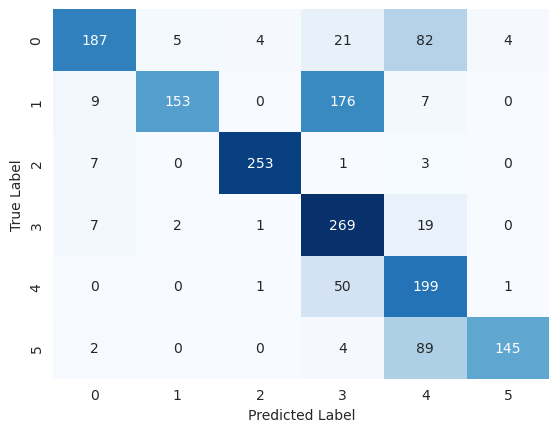

Accuracy: 0.7090
Precision: 0.7995
Recall: 0.7198
F1 Score: 0.7187


In [16]:
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np

# 定义数据集类
class MyDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]).float(), torch.tensor(self.target[idx])

# 定义神经网络模型类
class Net(nn.Module):
    def __init__(self,feature_num):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(feature_num, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dp1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dp2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dp3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(32, 8)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dp1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dp2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dp3(x)
        x = self.fc4(x)
        return x



# 加载数据
data = pd.read_csv('./feature/feautre.csv', header=None)
data = data.values.astype(np.float32)
target = data[:, -1].astype(np.int64)
data = data[:, :-2]
print(data.shape)
data = MinMaxScaler().fit_transform(data) # 缩放到[0, 1]
data= StandardScaler().fit_transform(data)
# 划分数据集
# train_data = data[:1000]
# train_target = target[:1000]
# test_data = data[1000:]
# test_target = target[1000:]
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=66)
print(train_data[0].size)
feature_num=train_data[0].size
# 创建数据加载器
batch_size = 32
train_dataset = MyDataset(train_data, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MyDataset(test_data, test_target)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 创建模型和优化器
model = Net(feature_num)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
epochs = 500
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 测试模型
model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        y_true.extend(target.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())

test_loss /= len(test_loader.dataset)
print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# 计算准确率、精确率、召回率、F1分数
report = classification_report(y_true, y_pred, digits=4)
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


Epoch: 10 Train Loss: 0.022148 Train Acc: 75.38% Test Loss: 0.019110 Test Acc: 81.89%
Epoch: 20 Train Loss: 0.021745 Train Acc: 76.29% Test Loss: 0.021038 Test Acc: 75.66%
Epoch: 30 Train Loss: 0.021651 Train Acc: 76.90% Test Loss: 0.021921 Test Acc: 78.66%
Epoch: 40 Train Loss: 0.022210 Train Acc: 75.47% Test Loss: 0.020595 Test Acc: 78.31%
Epoch: 50 Train Loss: 0.021877 Train Acc: 76.13% Test Loss: 0.021828 Test Acc: 76.90%
Epoch: 60 Train Loss: 0.021740 Train Acc: 75.94% Test Loss: 0.025486 Test Acc: 70.43%
Epoch: 70 Train Loss: 0.021048 Train Acc: 76.93% Test Loss: 0.025647 Test Acc: 71.78%
Epoch: 80 Train Loss: 0.021293 Train Acc: 75.97% Test Loss: 0.025751 Test Acc: 71.02%
Epoch: 90 Train Loss: 0.021472 Train Acc: 76.32% Test Loss: 0.019867 Test Acc: 79.84%
Epoch: 100 Train Loss: 0.021302 Train Acc: 76.38% Test Loss: 0.020271 Test Acc: 76.60%
Epoch: 110 Train Loss: 0.021321 Train Acc: 76.57% Test Loss: 0.020257 Test Acc: 80.25%
Epoch: 120 Train Loss: 0.021061 Train Acc: 76.91% Te

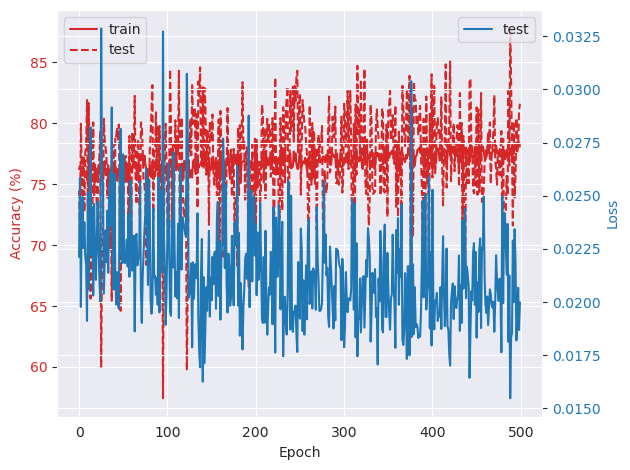

In [17]:
# 创建空列表，用于存储训练准确率、测试准确率和测试误差
train_acc_list = []
test_acc_list = []
test_loss_list = []

# 训练模型
for epoch in range(1, epochs + 1):
    train_loss = 0
    train_correct = 0
    model.train()  # 将模型设置为训练模式
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_acc_list.append(train_acc)

    test_loss = 0
    test_correct = 0
    model.eval()   # 将模型设置为测试模式
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            test_correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_acc = 100. * test_correct / len(test_loader.dataset)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

    if epoch % 10 == 0:
        print('Epoch: {} Train Loss: {:.6f} Train Acc: {:.2f}% Test Loss: {:.6f} Test Acc: {:.2f}%'.format(
            epoch, train_loss, train_acc, test_loss, test_acc))

# 绘制训练准确率、测试准确率和测试误差随epoch变化的曲线
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)', color=color)
ax1.plot(train_acc_list, color=color, label='train')
ax1.plot(test_acc_list, '--', color=color, label='test')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(test_loss_list, color=color, label='test')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
